In [2]:
import pandas as pd
import os, sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from utils.time_utils import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# base_dir = "/n/holylabs/LABS/idreos_lab/Users/azhao/gpu_profiling"
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"

# MM

In [7]:
"""
Note: using final I/O is only a rough heuristic for data movement.
"""
time_processor_conv2d = TimeProcessorMM(base_dir)
df = time_processor_conv2d.get_data(sample_rate=0.5)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)
plt.show()

/n/holylabs/LABS/idreos_lab/Users/azhao/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


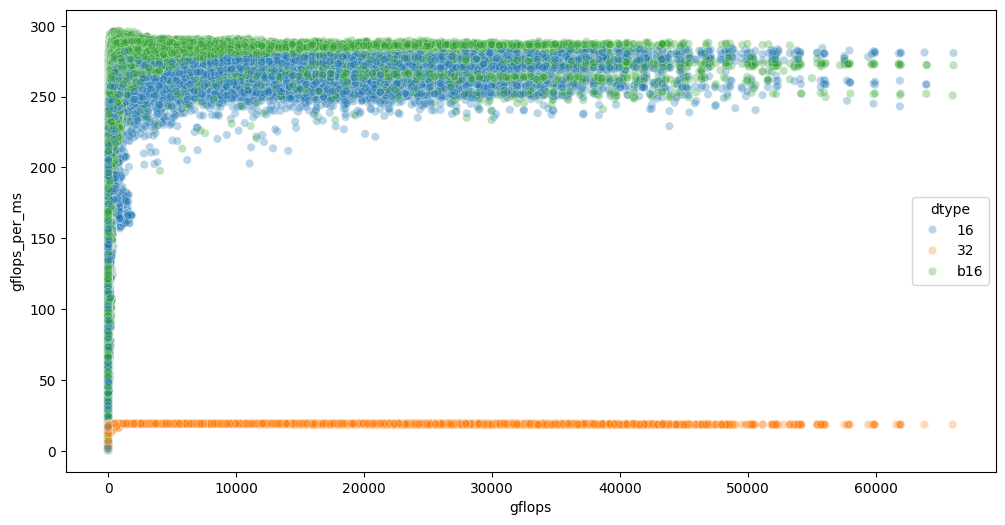

In [4]:
plt.figure(figsize=(12,6))
sns.scatterplot(x="gflops", y="gflops_per_ms", hue="dtype", alpha=0.3, data=df)
plt.show()

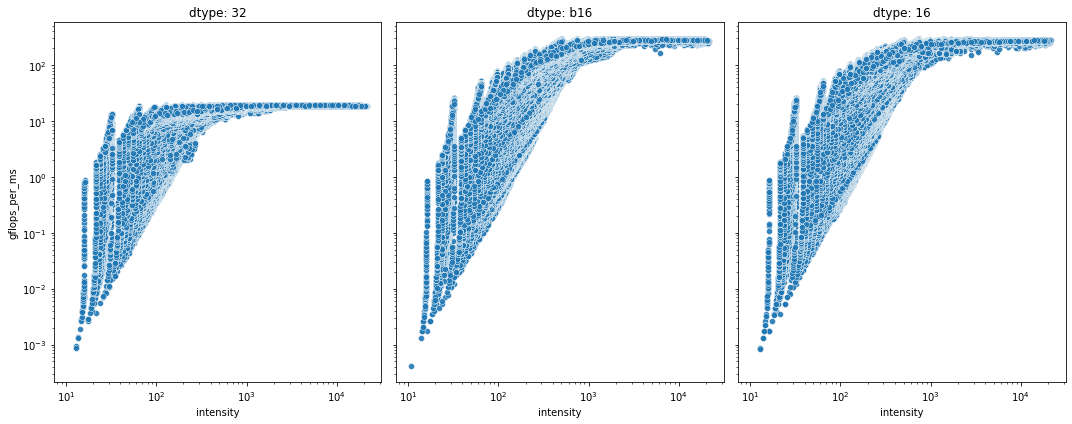

In [5]:
df["memory_accesses"] = df["n"] * df["m"] + df["m"] * df["p"] + df["n"] * df["p"]
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dtype in enumerate(["32", "b16", "16"]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", alpha=0.9, data=df.query(f"dtype == '{dtype}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}")
    
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [6]:
300 * 1000 * 2

600000

In [7]:
# Let's say 80 teraflops per second, which is half of the specified.
20 * 4

80000

# BMM

Similar amounts

100%|██████████| 72/72 [03:06<00:00,  2.60s/it]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


<AxesSubplot:>

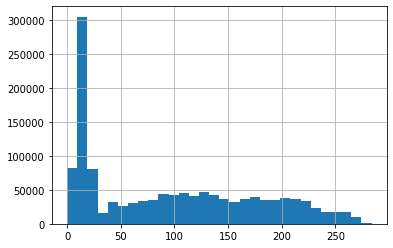

In [8]:
time_processor_conv2d = TimeProcessorBMM(base_dir)
df = time_processor_conv2d.get_data(sample_rate=0.1)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)

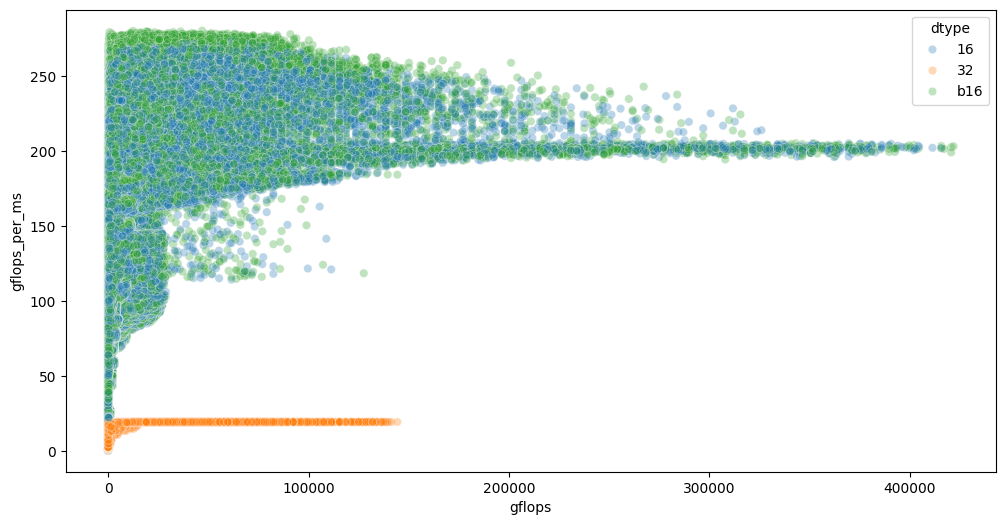

In [13]:
plt.figure(figsize=(12,6))
sns.scatterplot(x="gflops", y="gflops_per_ms", hue="dtype", alpha=0.3, data=df)
plt.show()

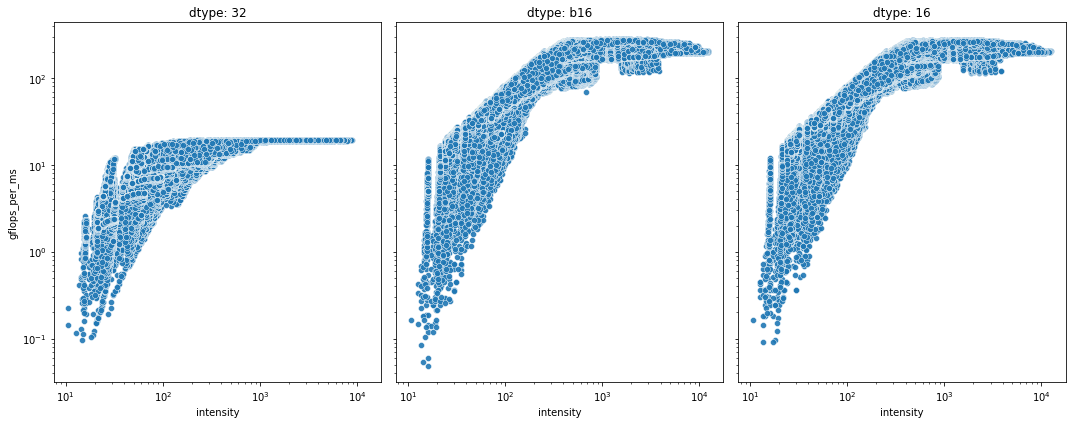

In [9]:
df["memory_accesses"] = df["b"] * (df["n"] * df["m"] + df["m"] * df["p"] + df["n"] * df["p"])
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dtype in enumerate(["32", "b16", "16"]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", alpha=0.9, data=df.query(f"dtype == '{dtype}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}")
    
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# SDPA

16it [00:08,  1.80it/s]
100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


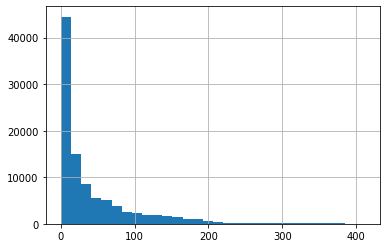

In [15]:
time_processor_sdpa = TimeProcessorSDPA(base_dir)
df = time_processor_sdpa.get_data(sample_rate=0.7)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)
plt.show()

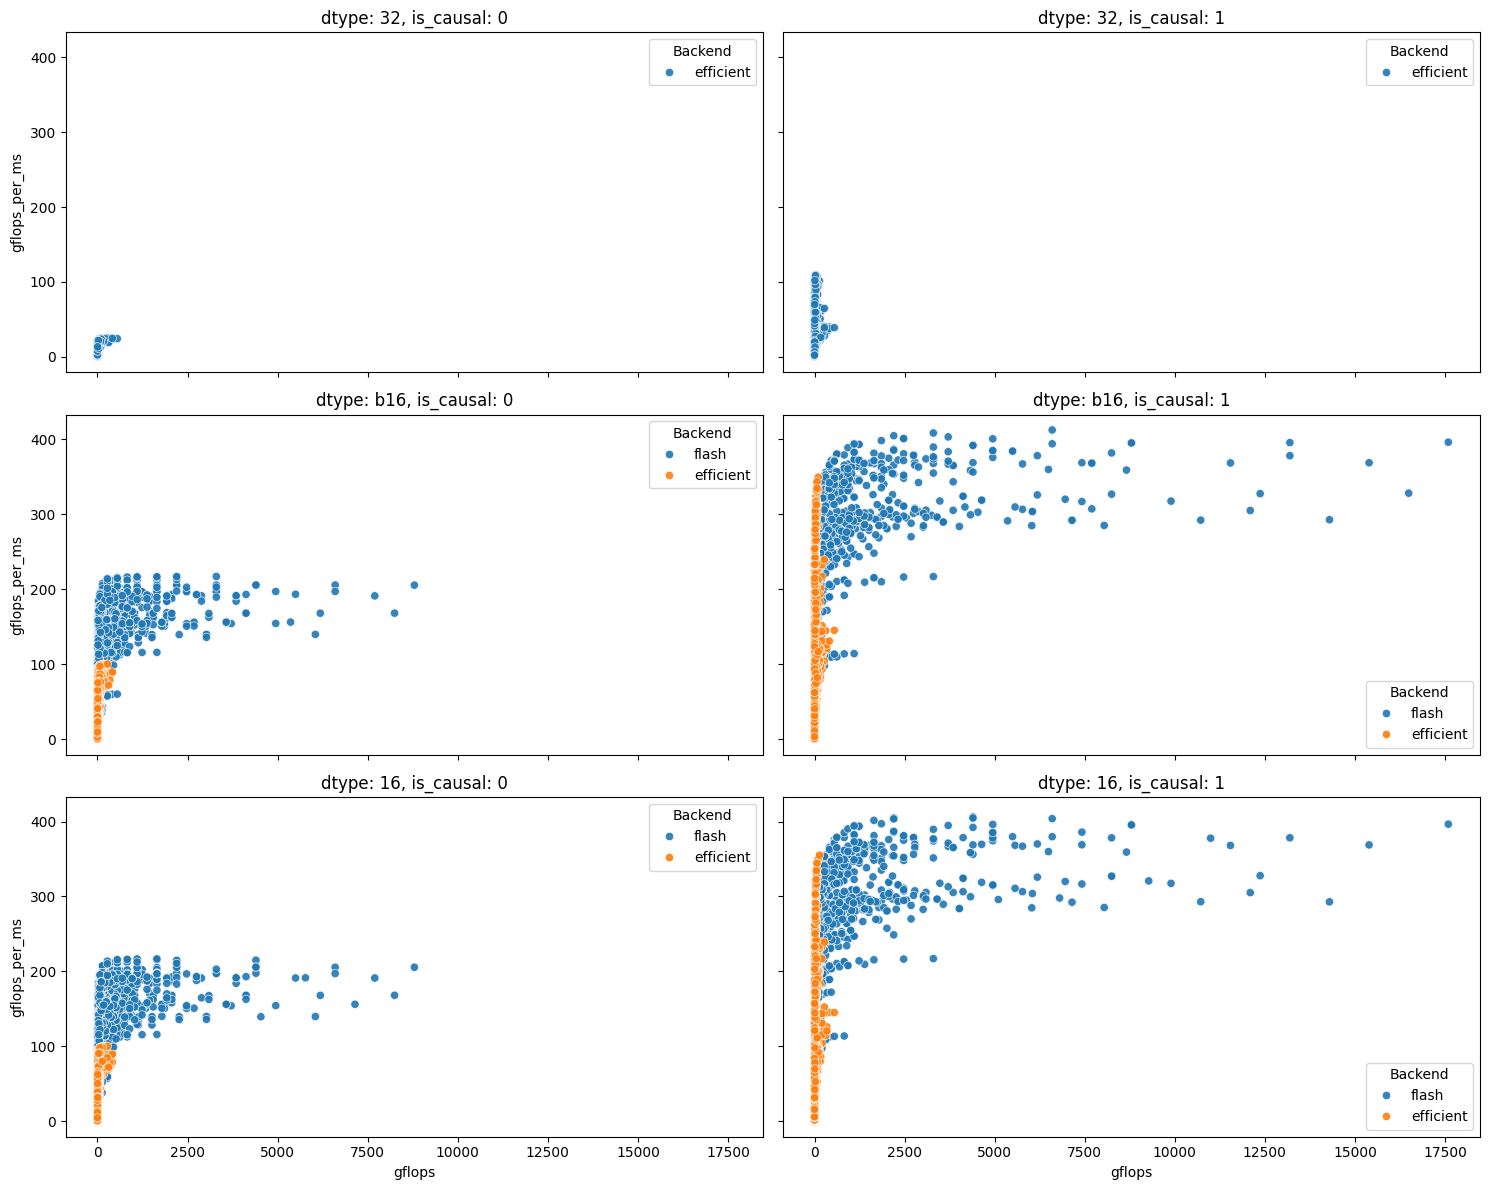

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, is_causal) in enumerate([(dtype, is_causal) for dtype in ["32", "b16", "16"] for is_causal in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="gflops", y="gflops_per_ms", hue="backend", alpha=0.9, data=df.query(f"dtype == '{dtype}' and is_causal == '{is_causal}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, is_causal: {is_causal}")
    ax.legend(title="Backend", loc='best')
plt.tight_layout()
plt.show()

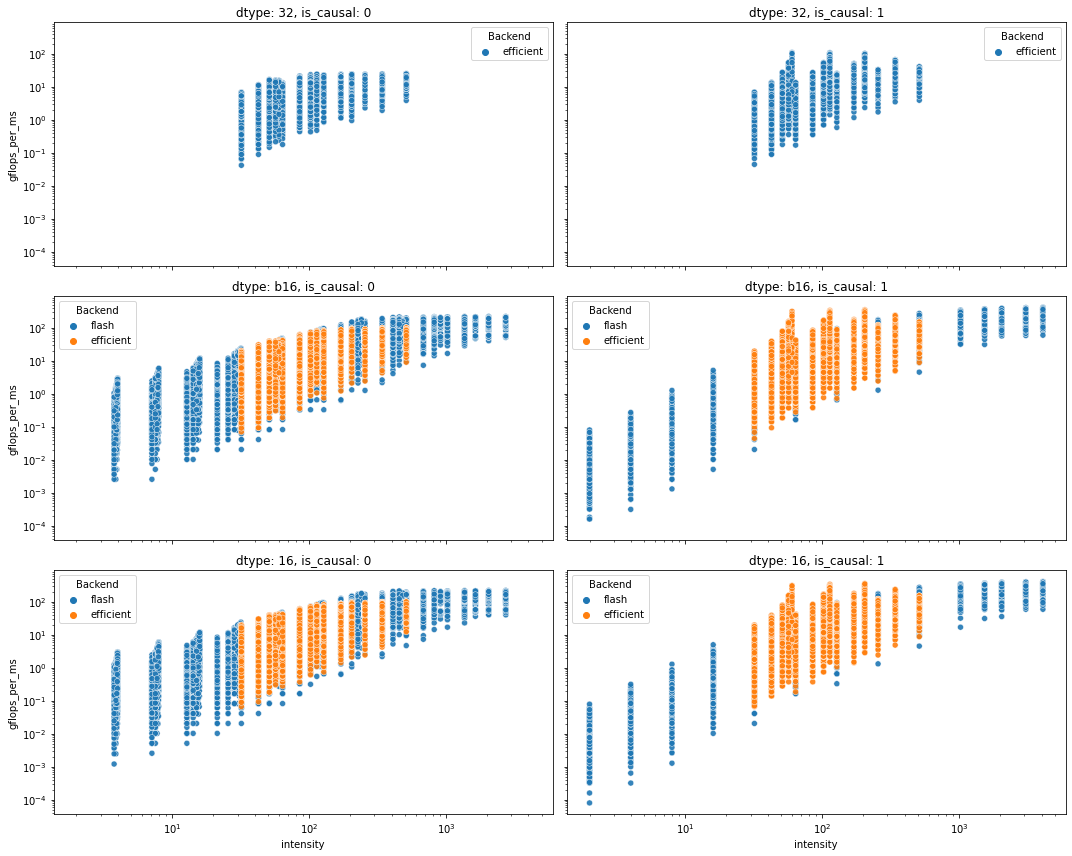

In [18]:
df["memory_accesses"] = (
    df["b"] * df["h"] * df["s_q"] * df["d_qk"] +  # Reading Q
    df["b"] * df["h"] * df["s_kv"] * df["d_qk"] +  # Reading K
    df["b"] * df["h"] * df["s_kv"] * df["d_v"] +   # Reading V
    df["b"] * df["h"] * df["s_q"] * df["d_v"]      # Writing Output
)
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, is_causal) in enumerate([(dtype, is_causal) for dtype in ["32", "b16", "16"] for is_causal in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", hue="backend", alpha=0.9, data=df.query(f"dtype == '{dtype}' and is_causal == '{is_causal}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, is_causal: {is_causal}")
    ax.legend(title="Backend", loc='best')

ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# SDPA Backward

16it [00:07,  2.05it/s]
100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


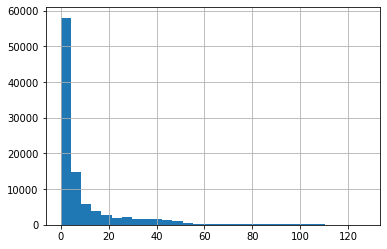

In [25]:
time_processor_sdpa = TimeProcessorSDPA(base_dir, is_forward=False)
df = time_processor_sdpa.get_data(sample_rate=0.7)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)
plt.show()

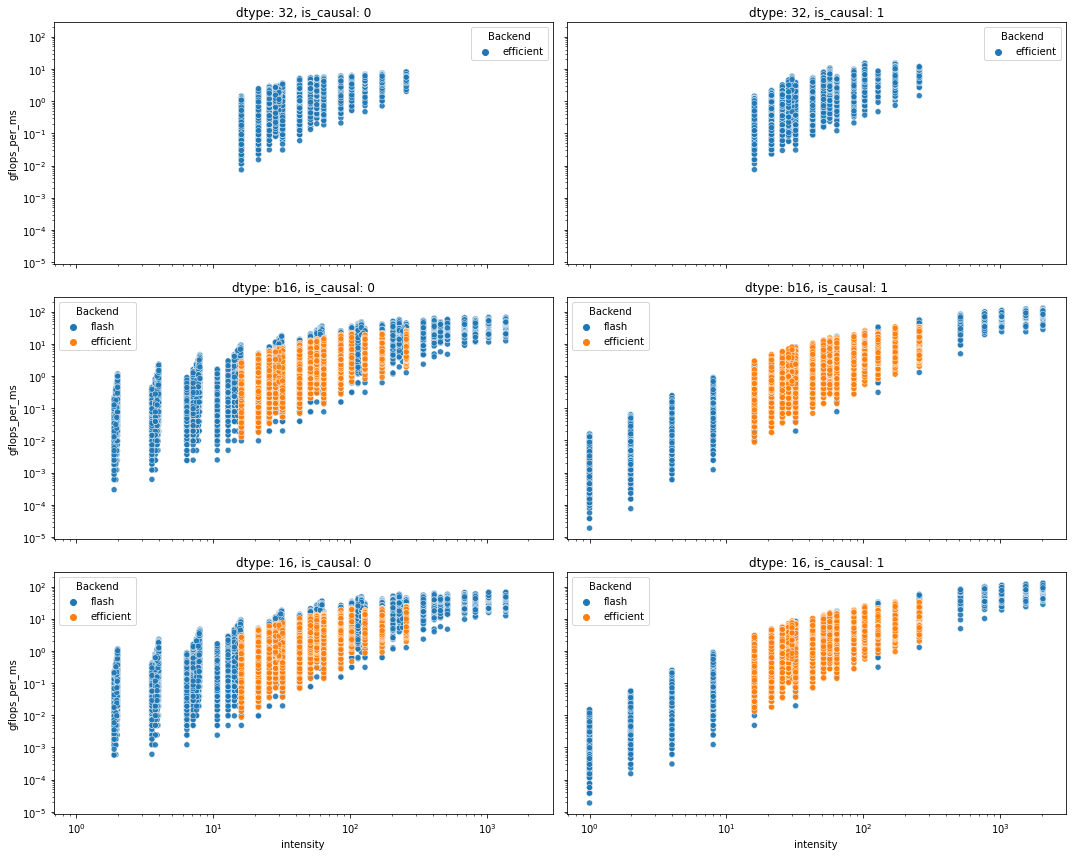

In [26]:
df["memory_accesses"] = 2 * (
    df["b"] * df["h"] * df["s_q"] * df["d_qk"] +  # dQ
    df["b"] * df["h"] * df["s_kv"] * df["d_qk"] +  # dK
    df["b"] * df["h"] * df["s_kv"] * df["d_v"] +   # dV
    df["b"] * df["h"] * df["s_q"] * df["d_v"]      # dOut
)
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, is_causal) in enumerate([(dtype, is_causal) for dtype in ["32", "b16", "16"] for is_causal in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", hue="backend", alpha=0.9, data=df.query(f"dtype == '{dtype}' and is_causal == '{is_causal}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, is_causal: {is_causal}")
    ax.legend(title="Backend", loc='best')

ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# Conv2d

34it [00:11,  1.93it/s]

< 0 found in file time.32.1024.0.pkl


44it [00:15,  2.20it/s]

< 0 found in file time.128.512.0.pkl


46it [00:16,  2.87it/s]

< 0 found in file time.128.1024.0.pkl


54it [00:18,  2.54it/s]

< 0 found in file time.512.128.0.pkl


56it [00:19,  3.53it/s]

< 0 found in file time.512.512.0.pkl


58it [00:19,  4.50it/s]

< 0 found in file time.512.1024.0.pkl
< 0 found in file time.512.1024.1.pkl


64it [00:20,  4.28it/s]

< 0 found in file time.1024.32.0.pkl


66it [00:21,  5.03it/s]

< 0 found in file time.1024.128.0.pkl


72it [00:21,  3.38it/s]


< 0 found in file time.1024.512.0.pkl
< 0 found in file time.1024.512.1.pkl
< 0 found in file time.1024.1024.0.pkl
< 0 found in file time.1024.1024.1.pkl


/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:297: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


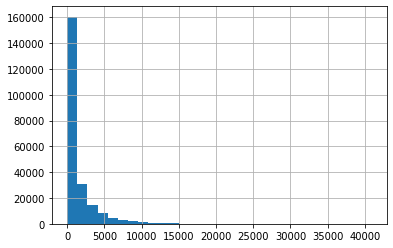

In [19]:
time_processor_conv2d = TimeProcessorConv2d(base_dir)
df = time_processor_conv2d.get_data(sample_rate=0.5)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)
plt.show()

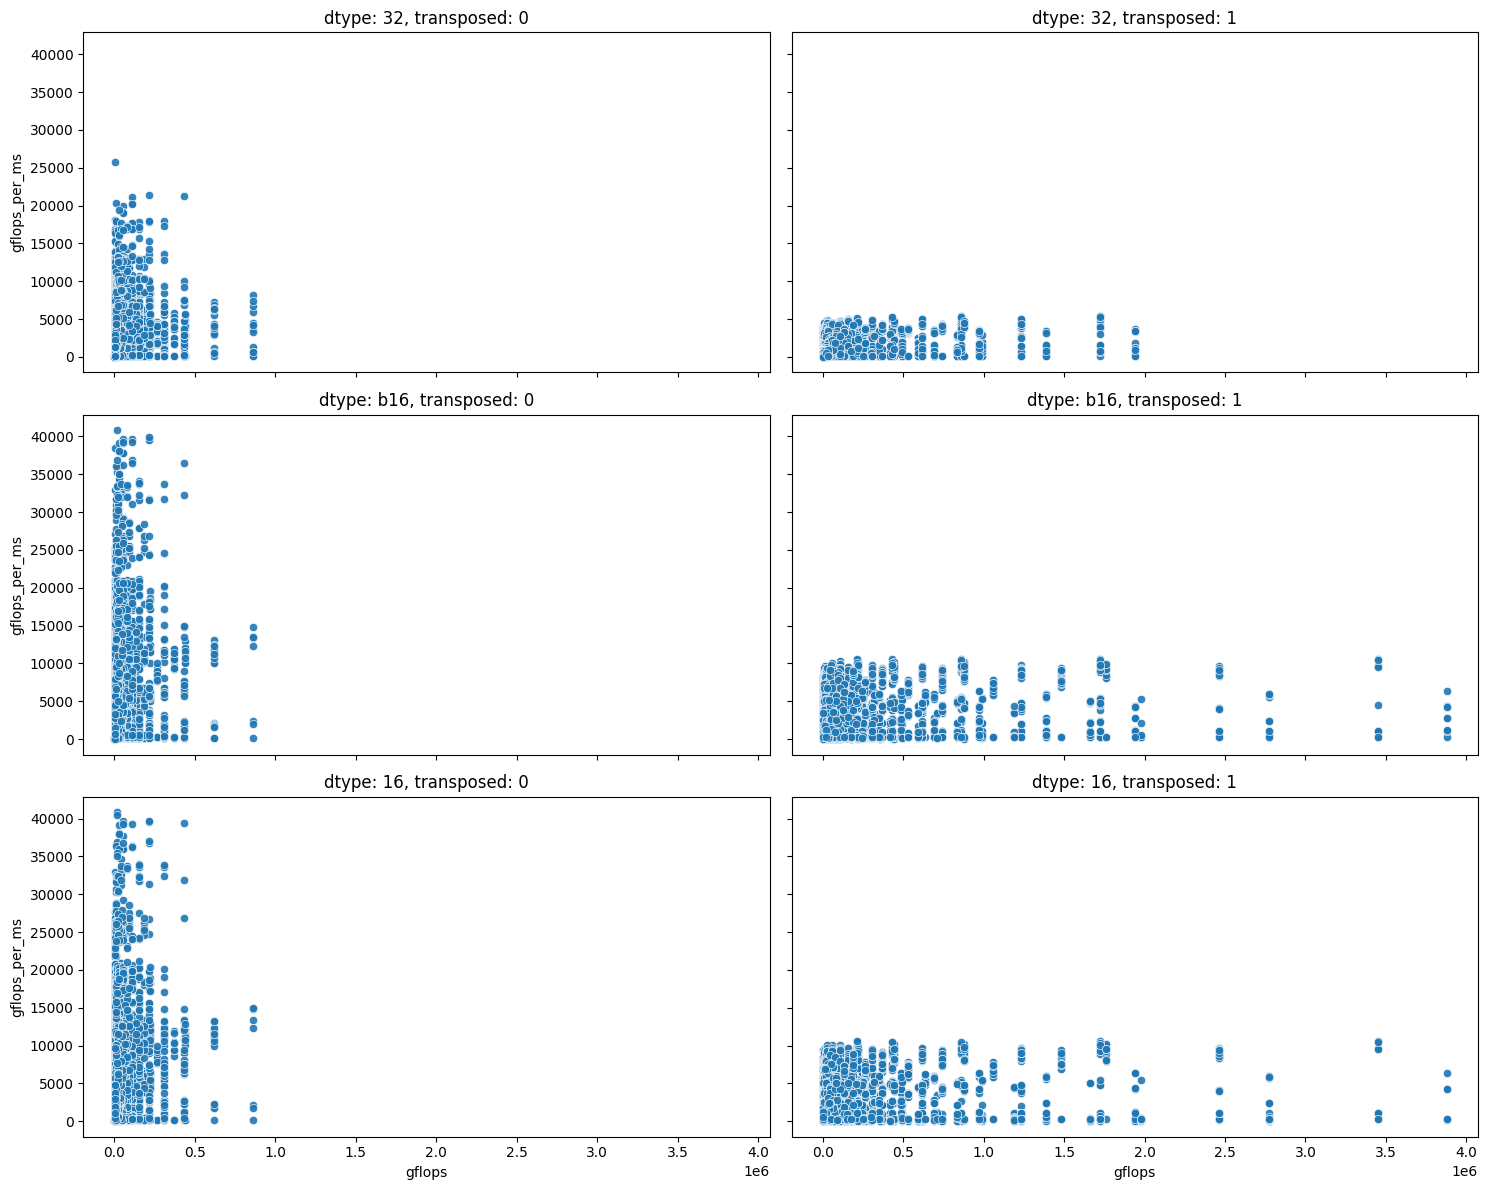

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, transposed) in enumerate([(dtype, transposed) for dtype in ["32", "b16", "16"] for transposed in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="gflops", y="gflops_per_ms", alpha=0.9, data=df.query(f"dtype == '{dtype}' and transposed == '{transposed}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, transposed: {transposed}")
plt.tight_layout()
plt.show()

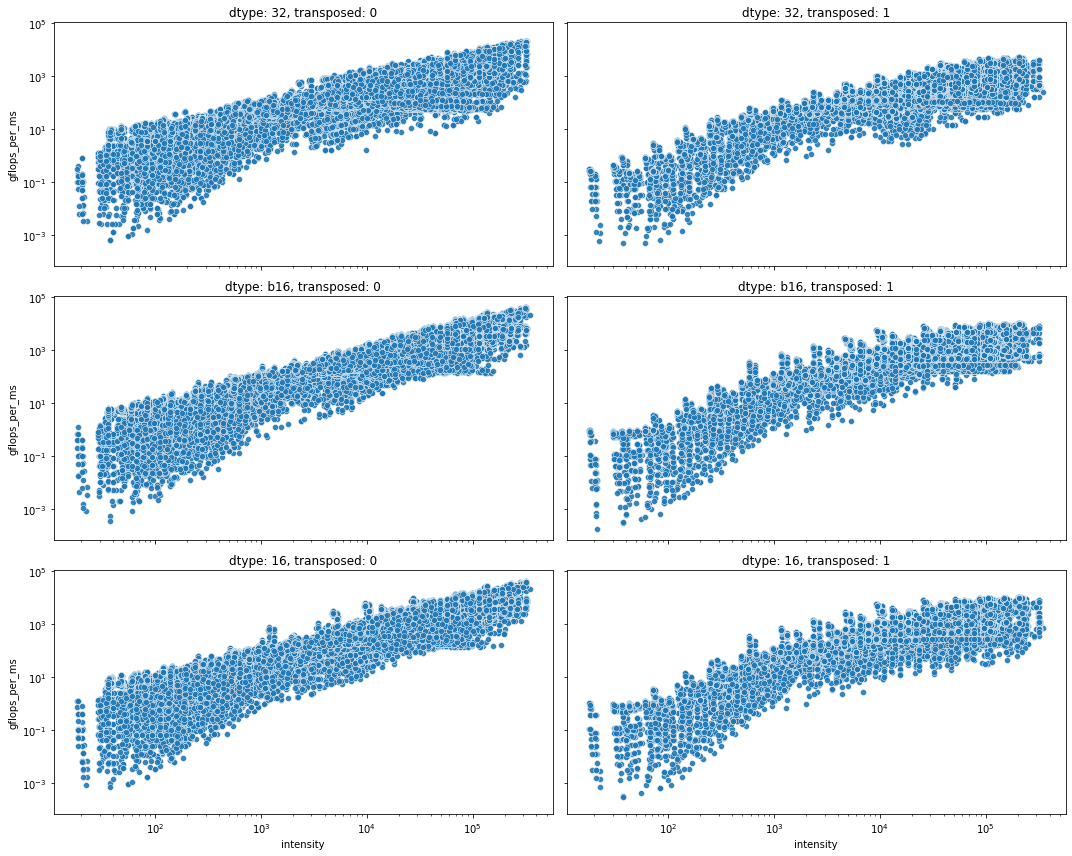

In [20]:
# output
df["oH"] = ((df["iH"] + 0 - df["dilation"] * (df["kH"] - 1) - 1) // df["stride"]) + 1
df["oW"] = ((df["iW"] + 0 - df["dilation"] * (df["kW"] - 1) - 1) // df["stride"]) + 1

# input, kernel, and output
input_memory_accesses = df["b"] * df["in_channels"] * df["iH"] * df["iW"]
kernel_memory_accesses = df["out_channels"] * (df["in_channels"] // df["groups"]) * df["kH"] * df["kW"]
output_memory_accesses = df["b"] * df["out_channels"] * df["oH"] * df["oW"]

df["memory_accesses"] = input_memory_accesses + kernel_memory_accesses + output_memory_accesses
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, transposed) in enumerate([(dtype, transposed) for dtype in ["32", "b16", "16"] for transposed in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", alpha=0.9, data=df.query(f"dtype == '{dtype}' and transposed == '{transposed}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, transposed: {transposed}")
    
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# Conv2d Transposed

34it [00:11,  1.95it/s]

< 0 found in file time.32.1024.0.pkl


44it [00:15,  1.81it/s]

< 0 found in file time.128.512.0.pkl


46it [00:15,  2.74it/s]

< 0 found in file time.128.1024.0.pkl


54it [00:19,  2.21it/s]

< 0 found in file time.512.128.0.pkl


56it [00:19,  2.82it/s]

< 0 found in file time.512.512.0.pkl
< 0 found in file time.512.512.1.pkl
< 0 found in file time.512.1024.0.pkl
< 0 found in file time.512.1024.1.pkl


64it [00:20,  4.55it/s]

< 0 found in file time.1024.32.0.pkl


72it [00:21,  3.41it/s]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:297: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


< 0 found in file time.1024.128.0.pkl
< 0 found in file time.1024.128.1.pkl
< 0 found in file time.1024.512.0.pkl
< 0 found in file time.1024.512.1.pkl
< 0 found in file time.1024.1024.0.pkl
< 0 found in file time.1024.1024.1.pkl


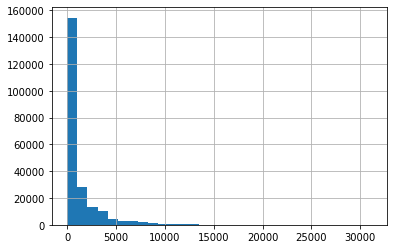

In [27]:
time_processor_conv2d = TimeProcessorConv2d(base_dir, is_forward=False)
df = time_processor_conv2d.get_data(sample_rate=0.5)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)
plt.show()

In [29]:
"""
TODO: verify these times
"""

df["oH"] = ((df["iH"] + 0 - df["dilation"] * (df["kH"] - 1) - 1) // df["stride"]) + 1
df["oW"] = ((df["iW"] + 0 - df["dilation"] * (df["kW"] - 1) - 1) // df["stride"]) + 1

input_memory_accesses = df["b"] * df["in_channels"] * df["iH"] * df["iW"]
kernel_memory_accesses = df["out_channels"] * (df["in_channels"] // df["groups"]) * df["kH"] * df["kW"]
output_memory_accesses = df["b"] * df["out_channels"] * df["oH"] * df["oW"]

# For backward pass, we also need to consider the gradients
dout_memory_accesses = output_memory_accesses

# Gradients with respect to input (dInput) and kernel (dKernel)
dinput_memory_accesses = input_memory_accesses  # Memory accesses to compute and store dInput
dkernel_memory_accesses = kernel_memory_accesses  # Memory accesses to compute and store dKernel

# Total memory accesses in the backward pass
df["memory_accesses"] = (
    2 * (input_memory_accesses + kernel_memory_accesses + output_memory_accesses)  # Forward pass reads/writes
    + dout_memory_accesses  # Reading the gradient of the output (dOut)
    + dinput_memory_accesses  # Reading/writing the gradient with respect to the input (dInput)
    + dkernel_memory_accesses  # Reading/writing the gradient with respect to the kernel (dKernel)
)
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

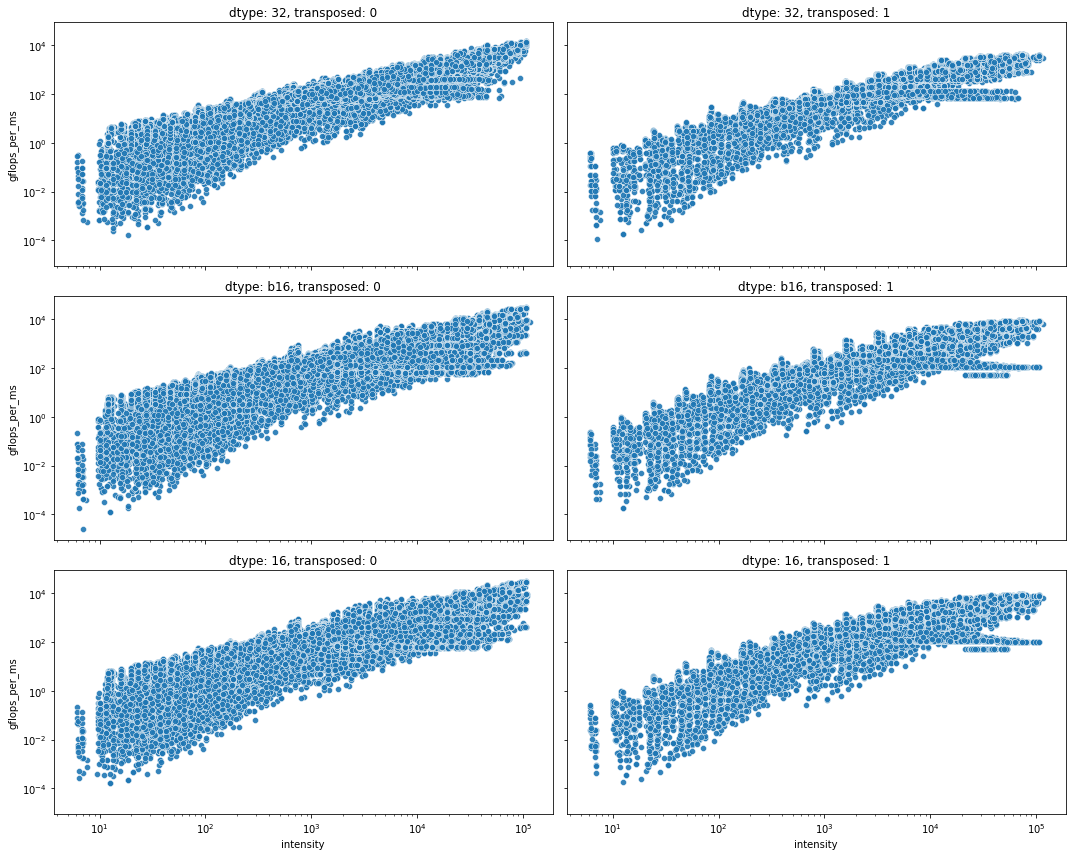

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, transposed) in enumerate([(dtype, transposed) for dtype in ["32", "b16", "16"] for transposed in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", alpha=0.9, data=df.query(f"dtype == '{dtype}' and transposed == '{transposed}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, transposed: {transposed}")
    
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()